For MS training we have 3 datasets: train, validation and holdout

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib

from scipy import interp
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import os
import time
import h5py

from config import *
from utils import specificity, sensitivity, balanced_accuracy, shuffle_data, normalize_float

In [2]:
# Start timing
start_time = time.time()

In [3]:
zero_one_normalize = False
dtype = np.float32

In [5]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset_FLAIR_lesions_filled.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset_FLAIR_lesions_filled.h5', 'r')

# loading only labels from original file
y_train = train_h5['y']
y_holdout = holdout_h5['y']

train_lesions_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset_lesions.h5', 'r')
holdout_lesions_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset_lesions.h5', 'r')

lesion_masks_train = train_lesions_h5['masks']
lesion_masks_holdout = holdout_lesions_h5['masks']

## Convert to lesion volume

In [6]:
# convert data to numpy arrays using lesions masks
X_train = np.array(lesion_masks_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(lesion_masks_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [7]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(y_train[y_train==0.])))
print("Number of MS patients: {}".format(len(y_train[y_train==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [8]:
# sum over all dimensions
X_train = np.sum(X_train, axis=(1, 2, 3)).reshape(-1, 1)
X_holdout = np.sum(X_holdout, axis=(1, 2, 3)).reshape(-1, 1)

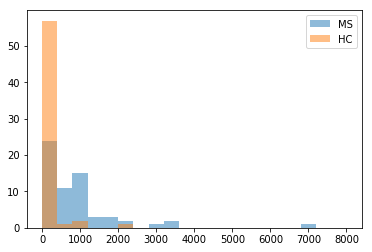

In [9]:
_, bins, _ = plt.hist(X_train[y_train==1.], bins=20, alpha=0.5, range=[0, 8000])
_ = plt.hist(X_train[y_train==0.], bins=bins, alpha=0.5, range=[0, 8000])
plt.legend(["MS", "HC"])

## Normalization

In [10]:
def normalize(train, test):
    # get training set moments
    mean = np.mean(train)
    std = np.std(train)
    # apply on train and test
    train = (train - mean)/std
    test = (test - mean)/std
    return train, test

## Training

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

def svc_param_selection(X, y, n_folds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    kernels = ['linear', 'rbf']
    param_grid = {'svc__C': Cs,
                  'svc__kernel': kernels}
    # use standard scaler for preprocessing
    scaler = preprocessing.StandardScaler()
    pipeline = make_pipeline(scaler, SVC(gamma='auto'))
    grid_search = GridSearchCV(pipeline, param_grid, cv=n_folds, n_jobs=10)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_, grid_search.cv_results_

Fold 0


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best paramter value: {'svc__C': 10, 'svc__kernel': 'rbf'}
######## Training set results ########
Balanced accuracy 99.11 %
Sensitivity 98.21 %
Specificity 100.00 %
######## Validation set results ########
Balanced accuracy 81.82 %
Sensitivity 100.00 %
Specificity 63.64 %
Area Under the Receiver Operating Curve (ROC AUC score) 83.77
Fold 1
Best paramter value: {'svc__C': 10, 'svc__kernel': 'linear'}
######## Training set results ########
Balanced accuracy 80.62 %
Sensitivity 69.09 %
Specificity 92.16 %
######## Validation set results ########
Balanced accuracy 81.25 %
Sensitivity 62.50 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 95.00
Fold 2
Best paramter value: {'svc__C': 1, 'svc__kernel': 'rbf'}
######## Training set results ########
Balanced accuracy 98.04 %
Sensitivity 100.00 %
Specificity 96.08 %
######## Validation set results ########
Balanced accuracy 73.75 %
Sensitivity 87.50 %
Specificity 60.00 %
Area Under the Receiver Operating Curve (ROC A

/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:19

Best paramter value: {'svc__C': 10, 'svc__kernel': 'rbf'}
######## Training set results ########
Balanced accuracy 99.02 %
Sensitivity 98.04 %
Specificity 100.00 %
######## Validation set results ########
Balanced accuracy 70.83 %
Sensitivity 91.67 %
Specificity 50.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 77.08
Fold 4
Best paramter value: {'svc__C': 10, 'svc__kernel': 'rbf'}
######## Training set results ########
Balanced accuracy 99.04 %
Sensitivity 100.00 %
Specificity 98.08 %
######## Validation set results ########
Balanced accuracy 83.33 %
Sensitivity 100.00 %
Specificity 66.67 %
Area Under the Receiver Operating Curve (ROC AUC score) 90.12
Fold 5


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:19

Best paramter value: {'svc__C': 10, 'svc__kernel': 'rbf'}
######## Training set results ########
Balanced accuracy 98.13 %
Sensitivity 98.11 %
Specificity 98.15 %
######## Validation set results ########
Balanced accuracy 85.71 %
Sensitivity 100.00 %
Specificity 71.43 %
Area Under the Receiver Operating Curve (ROC AUC score) 80.00
Fold 6
Best paramter value: {'svc__C': 10, 'svc__kernel': 'linear'}


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


######## Training set results ########
Balanced accuracy 80.49 %
Sensitivity 68.52 %
Specificity 92.45 %
######## Validation set results ########
Balanced accuracy 88.89 %
Sensitivity 77.78 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 97.22
Training Time: 0.0h:0.0m:20.59779405593872s
######## Final results ########
Validation balanced accuracies: 
 [0.8181818181818181, 0.8125, 0.7375, 0.7083333333333333, 0.8333333333333333, 0.8571428571428572, 0.8888888888888888]
Validation balanced accuracies mean: 0.8079828901257472
Validation final sensitivities: 
 [1.0, 0.625, 0.875, 0.9166666666666666, 1.0, 1.0, 0.7777777777777778]
Validation final sensitivities' mean: 0.8849206349206348
Validation final specificities: 
 [0.6363636363636364, 1.0, 0.6, 0.5, 0.6666666666666666, 0.7142857142857143, 1.0]
Validation final specificities' mean: 0.7310451453308595
Mean ROC AUC score 85.72


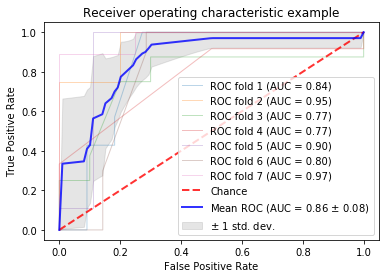

In [12]:
kf = KFold(n_splits=7)
fold = 0

best_params = []
train_balanced_accuracies = []
train_sensitivities = []
train_specificities = []

val_balanced_accuracies = []
val_sensitivities = []
val_specificities = []

auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

# shuffle the data once
X_train, y_train = shuffle_data(X_train, y_train)

# nested cross-validation
for train_idx, test_idx in kf.split(X_train):
    print("Fold %i" %fold)
    fold += 1
    
    # Start inner cross-validation
    best_param, cv_result = svc_param_selection(
        X_train[train_idx],
        y_train[train_idx],
        n_folds=5)
    
    print("Best paramter value: {}".format(best_param))
    
    model = SVC(kernel=best_param["svc__kernel"], C=best_param["svc__C"])
    model.fit(X_train[train_idx], y_train[train_idx])
    
    # training set results
    train_pred = model.predict(X_train[train_idx])
    train_bal_acc = balanced_accuracy(y_train[train_idx], train_pred)
    train_sens = sensitivity(y_train[train_idx], train_pred)
    train_spec = specificity(y_train[train_idx], train_pred)
    # val set results
    val_pred = model.predict(X_train[test_idx])
    val_scores = model.decision_function(X_train[test_idx])
    val_bal_acc = balanced_accuracy(y_train[test_idx], val_pred)
    val_sens = sensitivity(y_train[test_idx], val_pred)
    val_spec = specificity(y_train[test_idx], val_pred)
    
    roc_auc = roc_auc_score(y_train[test_idx], val_scores)
    fpr, tpr, thresholds = roc_curve(y_train[test_idx], val_scores)   
    
    # Store results
    best_params.append(best_param)
    train_balanced_accuracies.append(train_bal_acc)
    train_sensitivities.append(train_sens)
    train_specificities.append(train_spec)
    val_balanced_accuracies.append(val_bal_acc)
    val_sensitivities.append(val_sens)
    val_specificities.append(val_spec)
    
    auc_scores.append(roc_auc)
    # interpolate with diagonal to get comparable results
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0 # correct lowest value after interpolation

    # Print results
    print("######## Training set results ########")
    print("Balanced accuracy {:.2f} %".format(train_bal_acc*100))
    print("Sensitivity {:.2f} %".format(train_sens*100))
    print("Specificity {:.2f} %".format(train_spec*100))
    print("######## Validation set results ########")
    print("Balanced accuracy {:.2f} %".format(val_bal_acc*100))
    print("Sensitivity {:.2f} %".format(val_sens*100))
    print("Specificity {:.2f} %".format(val_spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (fold, roc_auc))
    
training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
# Print results
print("######## Final results ########")
print("Validation balanced accuracies: \n {}".format(val_balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(val_balanced_accuracies)))
print("Validation final sensitivities: \n {}".format(val_sensitivities))
print("Validation final sensitivities' mean: {}".format(np.mean(val_sensitivities)))
print("Validation final specificities: \n {}".format(val_specificities))
print("Validation final specificities' mean: {}".format(np.mean(val_specificities)))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # correct max value after interpolation and mean
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))

std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [13]:
training_time = time.time() - start_time

In [14]:
counter = {}

In [15]:
def majority_vote(best_params):
    """
    Find the most often used combination 
    of parameters.
    """
    assert(len(best_params)>=1)
    counter = {}
    # count unique value list
    for i in range(len(best_params)):
        # turn values into key
        new_key = ""
        for x in list(best_params[i].values()):
            new_key = new_key + str(x) + "_"
        if new_key in counter.keys():
            counter[new_key] += 1
        else:
            counter[new_key] = 1
    # select most frequent value list
    majority_param = max(counter, key=lambda key: counter[key])
    # reformat to list
    majority_param = majority_param[:-1].split("_")
    # reformat to dictionary
    result = {}
    for key, value in zip(best_params[0].keys(), majority_param):
        result[key] = value
    return result

In [16]:
majority_param = majority_vote(best_params)
print(majority_param)

{'svc__C': '10', 'svc__kernel': 'rbf'}


# Evaluation

Train on the entire training set with the best parameters from above and test on the holdout dataset for final performance.

Trial 0
######## Training set results ########
Balanced accuracy 80.85 %
Sensitivity 68.25 %
Specificity 93.44 %
######## Holdout set results ########
Balanced accuracy 88.46 %
Sensitivity 76.92 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 94.62
Trial 1
######## Training set results ########
Balanced accuracy 80.85 %
Sensitivity 68.25 %
Specificity 93.44 %
######## Holdout set results ########
Balanced accuracy 88.46 %
Sensitivity 76.92 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 94.62
Trial 2
######## Training set results ########
Balanced accuracy 80.85 %
Sensitivity 68.25 %
Specificity 93.44 %
######## Holdout set results ########
Balanced accuracy 88.46 %
Sensitivity 76.92 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 94.62
Trial 3
######## Training set results ########
Balanced accuracy 80.85 %
Sensitivity 68.25 %
Specificity 93.44 %
######## Holdout set results ########
Balanced 

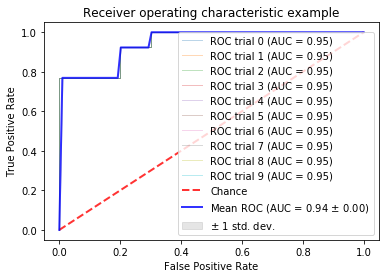

In [17]:
# training args
kernel = majority_param["svc__kernel"]
C = float(majority_param["svc__C"])
model = SVC(kernel=kernel, C=C)

num_trials = 10

train_balanced_accuracies = []
train_sensitivities = []
train_specificities = []

holdout_balanced_accuracies = []
holdout_sensitivities = []
holdout_specificities = []

auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(num_trials):
    print("Trial %i" %i)
    
    # shuffle the data each time
    X_train, y_train = shuffle_data(X_train, y_train)
    
    # normalize
    X_train, X_holdout = normalize(X_train, X_holdout)
    # Start training
    model.fit(X_train, y_train)
    # training set results
    train_pred = model.predict(X_train)
    train_bal_acc = balanced_accuracy(y_train, train_pred)
    train_sens = sensitivity(y_train, train_pred)
    train_spec = specificity(y_train, train_pred)
    # holdout set results
    holdout_pred = model.predict(X_holdout)
    holdout_scores = model.decision_function(X_holdout)
    holdout_bal_acc = balanced_accuracy(y_holdout, holdout_pred)
    holdout_sens = sensitivity(y_holdout, holdout_pred)
    holdout_spec = specificity(y_holdout, holdout_pred)
    
    roc_auc = roc_auc_score(y_holdout, holdout_scores)
    fpr, tpr, thresholds = roc_curve(y_holdout, holdout_scores)   
    
    # Store results
    train_balanced_accuracies.append(train_bal_acc)
    train_sensitivities.append(train_sens)
    train_specificities.append(train_spec)
    holdout_balanced_accuracies.append(holdout_bal_acc)
    holdout_sensitivities.append(holdout_sens)
    holdout_specificities.append(holdout_spec)
    
    auc_scores.append(roc_auc)
    # interpolate with diagonal to get comparable results
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0 # correct lowest value after interpolation

    # Print results
    print("######## Training set results ########")
    print("Balanced accuracy {:.2f} %".format(train_bal_acc*100))
    print("Sensitivity {:.2f} %".format(train_sens*100))
    print("Specificity {:.2f} %".format(train_spec*100))
    print("######## Holdout set results ########")
    print("Balanced accuracy {:.2f} %".format(holdout_bal_acc*100))
    print("Sensitivity {:.2f} %".format(holdout_sens*100))
    print("Specificity {:.2f} %".format(holdout_spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC trial %d (AUC = %0.2f)' % (i, roc_auc))
    
training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
# Print results
print("######## Final results ########")
print("Holdout balanced accuracies: \n {}".format(holdout_balanced_accuracies))
print("Holdout balanced accuracies mean: {}".format(np.mean(holdout_balanced_accuracies)))
print("Holdout final sensitivities: \n {}".format(holdout_sensitivities))
print("Holdout final sensitivities' mean: {}".format(np.mean(holdout_sensitivities)))
print("Holdout final specificities: \n {}".format(holdout_specificities))
print("Holdout final specificities' mean: {}".format(np.mean(holdout_specificities)))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # correct max value after interpolation and mean
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))

std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [18]:
total_time = time.time() - start_time

In [19]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

Training Time: 0.0h:0.0m:21.26303744316101s
Total time elapsed: 0.0h:0.0m:21.559102535247803s


In [20]:
quit()